In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
hm450_hg19=pd.read_csv('../data/hm450.hg19.manifest.bed', sep='\t', header=None)
hm450_hg19

,0,1,2,3,4
0,chr1,15864,15866,-,cg13869341
1,chr1,18826,18828,-,cg14008030
2,chr1,29406,29408,-,cg12045430
3,chr1,29424,29426,-,cg20826792
4,chr1,29434,29436,-,cg00381604
...,...,...,...,...,...
485572,chrM,6761,6763,-,cg05001044
485573,chrM,6797,6799,+,cg03344490
485574,chrM,7196,7198,-,cg18024856
485575,chrM,9054,9056,+,cg03348902


In [45]:
marker_to_chr_pos_tuple = dict(zip(hm450_hg19[4], zip(hm450_hg19[0], hm450_hg19[2] - 1)))

In [46]:
horvath_coef = pd.read_csv("../data/gb-2013-14-10-r115-S3.csv")
markers = horvath_coef["CpGmarker"]
coefs = horvath_coef["CoefficientTraining"]

In [47]:
horvath_chrs = markers.apply(marker_to_chr_pos_tuple.get)

In [48]:
data = pd.read_csv("../data/1000bp_imputed_cytosines.tsv", sep='\t')

In [49]:
chromosome, position = np.transpose([name.split(".") for name in data.values[:, 0]])
position = position.astype(int)

In [50]:
def compare_chr(chr1, p1, chr2, p2):
    return chr1 < chr2 or (chr1 == chr2 and p1 < p2)

def binary_search(c, p, lu="lower"):
    if lu == "lower":
        left = 0
        right = len(chromosome)
        while right - left > 1:
            mid = (right + left) // 2
            if compare_chr(c, p, chromosome[mid], position[mid]):
                right = mid
            else:
                left = mid
        return left
    if lu == "upper":
        left = -1
        right = len(chromosome) - 1
        while right - left > 1:
            mid = (right + left) // 2
            if compare_chr(chromosome[mid], position[mid], c, p):
                left = mid
            else:
                right = mid
        return right

In [51]:
horvath_ind_left = horvath_chrs.apply(lambda tup: binary_search(*tup))
horvath_ind_right = horvath_chrs.apply(lambda tup: binary_search(tup[0], tup[1] + 1))

In [52]:
# raw_data = pd.read_csv("../data/sorted_filtered_cytosines_freq.tsv", sep='\t')

In [53]:
data_values = data.values

def impute_row(chr, pos):
    i = binary_search(chr, pos - 500, "upper")
    j = binary_search(chr, pos + 500, "lower")
    if i > j:
        neighbours = []
        if chromosome[i] == chr:
            neighbours.append(data_values[i][1:])
        if chromosome[j] == chr:
            neighbours.append(data_values[j][1:])
        if len(neighbours) == 0:
            return "AAA error", True
        return np.mean(neighbours, axis=0), True
    return data_values[i:j + 1][:, 1:].mean(axis=0), False

features_arr = []
counter1, counter2 = 0, 0
for left_ind, right_ind, (chr, pos) in tqdm(list(zip(horvath_ind_left, horvath_ind_right, horvath_chrs))):
    if chromosome[left_ind] == chr and position[left_ind] == pos:
        res = data_values[int(left_ind), 1:]
        if chromosome[right_ind] == chr and position[right_ind] == pos + 1:
            res = np.mean([res, data_values[int(right_ind), 1:]], axis=0)
        features_arr.append(res)
    elif chromosome[right_ind] == chr and position[right_ind] == pos + 1:
        res = data_values[int(right_ind), 1:]
        features_arr.append(res)
    else:
        res1, sig1 = impute_row(chr, pos)
        res2, sig2 = impute_row(chr, pos + 1)
        counter1 += sig1
        counter2 += sig2
        features_arr.append(np.mean([res1, res2], axis=0))
features_arr = np.array(features_arr)

100%|██████████| 353/353 [00:06<00:00, 52.44it/s]


In [54]:
print(counter1, counter2, counter2 + counter1)

68 68 136


In [55]:
# absolute_missing = np.sum(np.isnan(features_arr.astype(float)), axis=0)
# relative_missing = absolute_missing / 84
# np.isnan(features_arr.astype(float)).sum()

In [56]:
# plt.bar(range(len(absolute_missing)), absolute_missing)

In [57]:
out = (data.values[horvath_ind_left][:, 1:] / 100).astype(np.float64).transpose().dot(coefs.astype(np.float64)) + 0.695507258

In [58]:
def F_inv(x):
    if x < 0:
        return 21 * np.exp(x) - 1
    else:
        return 21 * x + 20

In [59]:
predicted_age = np.vectorize(F_inv)(out)

In [60]:
real_age = pd.read_csv("../data/RRBS.phase1_yo_datasets.Monocyte.tsv", sep='\t')
real_age["Donor Age"] - predicted_age

0      5.169558
1     -8.735535
2     17.073503
3     -9.545233
4     -8.996503
5     -2.637561
6     -1.025419
7     12.139841
8    -18.137761
9     -4.542486
10    -7.088266
11   -10.111593
12    -4.143461
13    -7.863644
14   -15.820832
15     4.846245
16     2.082599
17   -18.015631
18     3.218279
19    -7.058708
20    44.069846
21    40.987054
22    42.110826
23    38.596692
24    44.815877
25    44.763164
26    27.370222
27    40.040092
28    48.073297
29    39.485840
30    42.854045
31    45.425714
32    56.399531
33    38.280452
34    46.975690
35    28.239770
36    43.244337
37    52.199623
38    45.211085
39    53.339009
Name: Donor Age, dtype: float64

In [63]:
def label(index):
    return 0 if index[0] == "Y" else 1

In [64]:
labels = real_age["Donor ID"].apply(label)

Text(0, 0.5, 'predicted age')

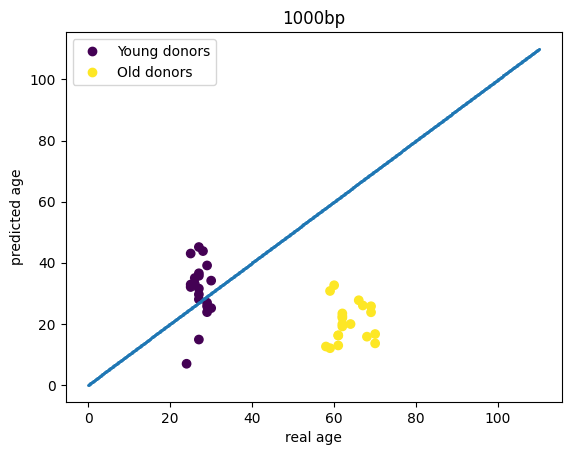

: 

In [86]:
scatter1 = plt.scatter(real_age["Donor Age"].astype(np.float64), predicted_age.astype(np.float64), c=labels)
plt.scatter(np.linspace(0, 110, 1000), np.linspace(0, 110, 1000), s=1)
plt.legend(handles=scatter1.legend_elements()[0], labels=["Young donors", "Old donors"])
plt.title("1000bp")
plt.xlabel('real age')
plt.ylabel('predicted age')

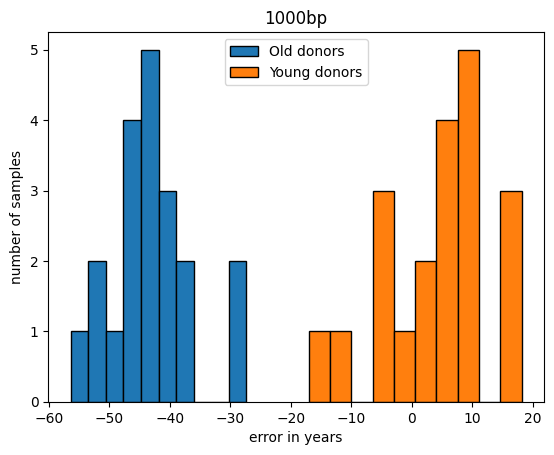

In [85]:
errors = predicted_age.astype(np.float64) - real_age["Donor Age"].astype(np.float64)
plt.hist(errors[labels.astype(bool)], ec="k", label="Old donors")
plt.hist(errors[np.invert(labels.astype(bool))], ec="k", label="Young donors")
plt.xlabel("error in years")  
plt.ylabel("number of samples")
plt.title("1000bp")
plt.legend()